In [1]:
# Shravan Singh 2173638

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
from datetime import datetime
import math
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

df = pd.read_csv('logbook_assignment1.csv')
df_tally = df.shape[0]
df.head(10)

c:\pyhton\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url
0,"Cooling System, Heating System, Lights, Spark ...",Apr 7 2022,"73,370",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...
1,Nov 7 2012,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,NaN,https://www.somewebsite.com/bmw/x3/2009/461150
2,Sep 22 2012,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,NaN,https://www.somewebsite.com/mercedes-benz/e300...
3,May 4 2019,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,NaN,https://www.somewebsite.com/bmw/320d/2010/247233
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4,https://www.somewebsite.com/honda/passport/201...
5,Oct 23 2021,Oct 23 2021,"147,567",3.413,$3.739,$12.76,29.0,NaN,https://www.somewebsite.com/volkswagen/passat/...
6,Nov 20 2021,Dec 12 2021,"105,929",9.044,$4.639,$41.96,29.5,NaN,https://www.somewebsite.com/mazda/3_sport/2010...
7,Jan 20 2022,Jan 20 2022,"59,475",14.962,$2.929,$43.82,27.3,NaN,https://www.somewebsite.com/subaru/forester/20...
8,NaN,Apr 16 2018,"137,562",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/kianival/2009/789684
9,NaN,Nov 29 2020,"99,296",2.710,$1.999,$5.42,0.0,NaN,https://www.somewebsite.com/lexus/rx350/2012/8...


## Question 1

### Question 1.1.1 - 1.1.3

In [2]:
date_fueled = df["date_fueled"].to_numpy()
date_captured = df["date_captured"].to_numpy()

format = "%b %d %Y"

count = 0 #Used to keep track of incorrect values
rows = len(date_fueled)
for i in range(rows):
    try:
        res = bool(datetime.strptime(date_fueled[i], format))
    except:
        count += 1
        try:
            #Checks if the date_captured value is a valid date and uses it as a placeholder at position i.
            res = bool(datetime.strptime(date_captured[i], format))
            if (res):
                date_fueled[i] = date_captured[i]
        except:
            continue
        continue
        
incorrect_percent = count / rows * 100
print("There are approxiamately " + "{:.3f}".format(incorrect_percent) + "% incorrect values.\n")

df["date_fueled"] = date_fueled

#Convert column to a date format setting invalid entries as 'NaT'
df["date_fueled"] = pd.to_datetime(df["date_fueled"], format = "%b %d %Y", errors = "coerce")

#There were a few incorrect dates that were detected as dates. We will get the locations of the dates and change them to the value in the 'date_captured' column.
incorrect = []
for i in range(rows):
    if (pd.isnull(df["date_fueled"].iloc[i])):
        incorrect.append(i)
        
for i in range(len(incorrect)):
    x = pd.to_datetime(df["date_captured"].iloc[incorrect[i]], format = "%b %d %Y", errors = "coerce")
    if (pd.isnull(x)):
        continue
    else:
        loc = incorrect[i]
        df.at[loc, "date_fueled"] = x
        
#Use info() to show datatype of column has been changed
df.info()

There are approxiamately 11.678% incorrect values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174870 entries, 0 to 1174869
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date_fueled      1174870 non-null  datetime64[ns]
 1   date_captured    1174870 non-null  object        
 2   odometer         1025716 non-null  object        
 3   gallons          1100660 non-null  object        
 4   cost_per_gallon  1094110 non-null  object        
 5   total_spent      1100660 non-null  object        
 6   mpg              1100660 non-null  object        
 7   miles            146274 non-null   object        
 8   user_url         1174870 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 80.7+ MB


### Question 1.1.4

In [3]:
#We will remove future dates and dates earlier than 2005
remove_2005 = df[~(df["date_fueled"].dt.year < 2005)]
remove_future = remove_2005[~(remove_2005["date_fueled"] > datetime.today().strftime('%Y-%m-%d'))]

df = remove_future
df = df.reset_index(drop=True)

### Question 1.1.5

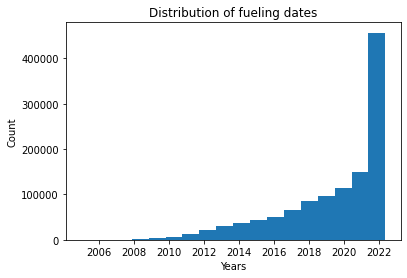

In [4]:
#Plot data distribution
plt.title("Distribution of fueling dates")
plt.xlabel("Years")
plt.ylabel("Count")
plt.hist(df["date_fueled"], bins=18)
plt.show()

From the above distribution we can see that the distribution is negatively skewed and that most of the data has been captured from 2021 upwards.

### Question 1.2.1

In [5]:
#Update number of rows after columns have been dropped.
rows = df.shape[0]

gallons_na = pd.isna(df["gallons"]).sum() / rows * 100
miles_na = pd.isna(df["miles"]).sum() / rows * 100
odometer_na = pd.isna(df["odometer"]).sum() / rows * 100

print("There are approxiamately: " + "{:.3f}".format(gallons_na) + "% gallons, " + "{:.3f}".format(miles_na) + "% miles, and " + "{:.3f}".format(odometer_na) + "% odometer entries missing.")

There are approxiamately: 6.316% gallons, 87.554% miles, and 12.691% odometer entries missing.


### Question 1.2.2 & 1.2.3

In [6]:
#Convert the respective columns to floats

df['gallons'] = df['gallons'].replace(',','', regex=True).astype(float)
df['miles'] = df['miles'].str.replace(',','', regex=True).astype(float)
df["mpg"] = df["mpg"].apply(pd.to_numeric,errors='coerce')

In [7]:
#Convert columns to numpy array and fill in NaN values from other columns
gallons = df["gallons"].to_numpy()
miles = df["miles"].to_numpy()
mpg  = df["mpg"].to_numpy()

for i in range(len(miles)):
    if math.isnan(miles[i]):
        if math.isnan(gallons[i]) or math.isnan(mpg[i]):
            pass
        else:
            miles[i] = gallons[i] * mpg[i]
    elif math.isnan(gallons[i]):
        if math.isnan(miles[i]) or math.isnan(mpg[i]):
            pass
        else:
            gallons[i] = 1 / mpg[i] * miles[i]
    elif math.isnan(mpg[i]):
        if math.isnan(miles[i]) or math.isnan(gallons[i]):
            pass
        elif gallons[i] == 0.0:
            pass
        else:
            mpg[i] = miles[i] / gallons[i]
            
#Put the data back into the dataframe
df["gallons"] = gallons
df["miles"] = miles
df["mpg"] = mpg

In [8]:
#Drop Null values
df = df.dropna(subset=['gallons', 'miles', 'mpg'])
df = df.reset_index(drop=True)

### Question 1.2.4

((array([1.097682e+06, 1.848000e+03, 5.000000e+02, 8.500000e+01,
         0.000000e+00, 2.000000e+00, 1.000000e+00, 0.000000e+00,
         1.000000e+00, 2.000000e+00]),
  array([   0.        ,  121.43366337,  242.86732673,  364.3009901 ,
          485.73465347,  607.16831683,  728.6019802 ,  850.03564356,
          971.46930693, 1092.9029703 , 1214.33663366]),
  <BarContainer object of 10 artists>),
 Text(0.5, 1.0, 'Distribution of MPG'))

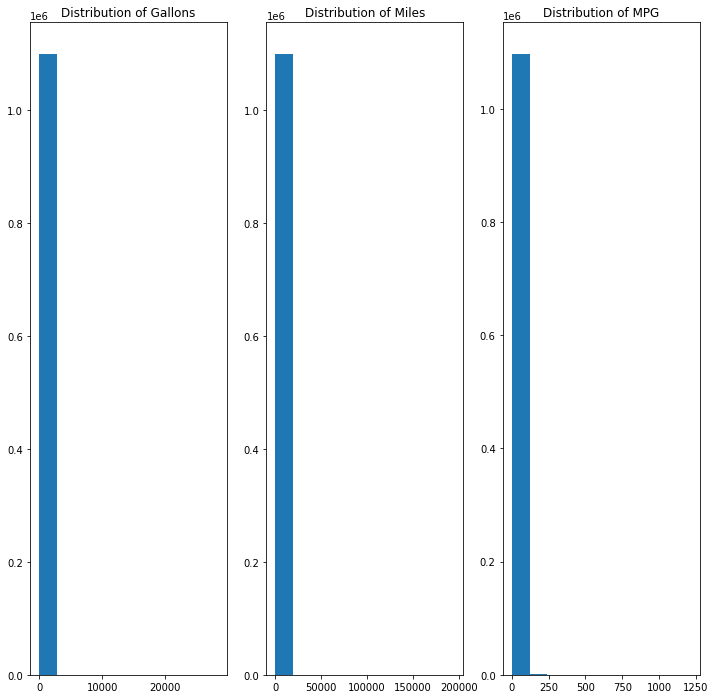

In [9]:
#Plot distributions
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
ax = axes.ravel()

ax[0].hist(gallons), ax[0].set_title("Distribution of Gallons")
ax[1].hist(miles), ax[1].set_title("Distribution of Miles")
ax[2].hist(mpg), ax[2].set_title("Distribution of MPG")

All the distributions appear to be positively skewed. Visually, we can also see that there are values (outliers) that are far greater than one standard deviation.

((array([8.21669168e-03, 1.38331923e-05, 3.74274684e-06, 6.36266963e-07,
         0.00000000e+00, 1.49709874e-08, 7.48549368e-09, 0.00000000e+00,
         7.48549368e-09, 1.49709874e-08]),
  array([   0.        ,  121.43366337,  242.86732673,  364.3009901 ,
          485.73465347,  607.16831683,  728.6019802 ,  850.03564356,
          971.46930693, 1092.9029703 , 1214.33663366]),
  <BarContainer object of 10 artists>),
 Text(0.5, 1.0, 'Distribution of MPG'))

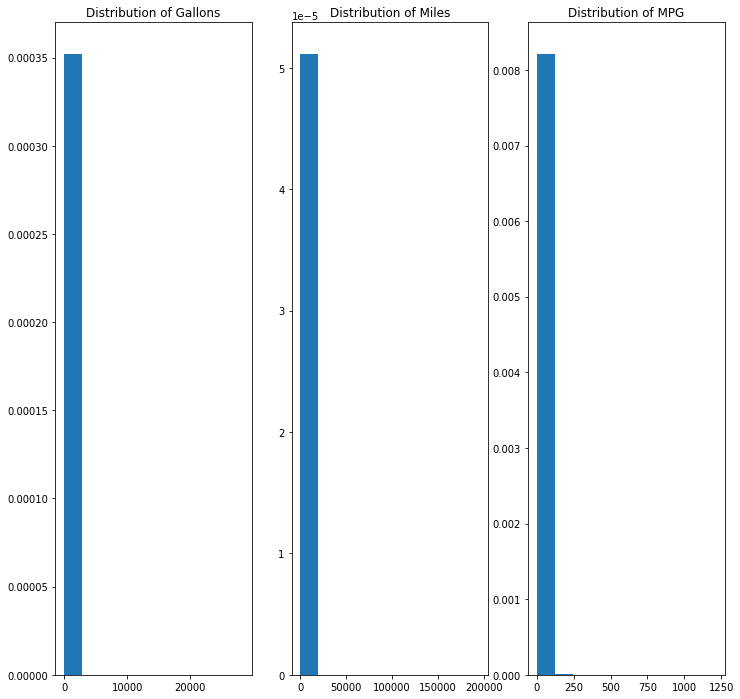

In [10]:
#Plot distributions
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
ax = axes.ravel()

ax[0].hist(gallons, density = True, stacked = True), ax[0].set_title("Distribution of Gallons")
ax[1].hist(miles, density = True, stacked = True), ax[1].set_title("Distribution of Miles")
ax[2].hist(mpg, density = True, stacked = True), ax[2].set_title("Distribution of MPG")

Normalisizng the distribution did not change the shape of the distribution.

### Question 1.2.5

In [11]:
df.describe()[["gallons", "miles", "mpg"]]

,gallons,miles,mpg
count,1.100121e+06,1.100121e+06,1.100121e+06
mean,1.279742e+01,2.694540e+02,2.216306e+01
std,7.448306e+01,7.257661e+02,1.574440e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.990000e+00,1.814000e+02,1.560000e+01
50%,1.195400e+01,2.670486e+02,2.180000e+01
75%,1.493900e+01,3.427644e+02,2.850000e+01
max,2.838000e+04,1.953212e+05,1.214337e+03


The results make sense as the data is not yet cleaned. For instance, the minimum value for all three columns is 0.0 which will likely be removed post-cleaning.

## Question 2 ##
### Question 2.1 ###

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100121 entries, 0 to 1100120
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date_fueled      1100121 non-null  datetime64[ns]
 1   date_captured    1100121 non-null  object        
 2   odometer         952462 non-null   object        
 3   gallons          1100121 non-null  float64       
 4   cost_per_gallon  1093573 non-null  object        
 5   total_spent      1100121 non-null  object        
 6   mpg              1100121 non-null  float64       
 7   miles            1100121 non-null  float64       
 8   user_url         1100121 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 75.5+ MB


In [13]:
df['currency'] = df['cost_per_gallon'].str.extract(r'(\D*)[\d\,\.]+(\D*)')[0]
df.head(10)

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency
0,2012-11-07,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,$
1,2012-09-22,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,£
2,2019-05-04,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,£
3,2022-02-15,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,$
4,2021-10-23,Oct 23 2021,"147,567",3.413,$3.739,$12.76,29.0,98.9770,https://www.somewebsite.com/volkswagen/passat/...,$
5,2021-11-20,Dec 12 2021,"105,929",9.044,$4.639,$41.96,29.5,266.7980,https://www.somewebsite.com/mazda/3_sport/2010...,$
6,2022-01-20,Jan 20 2022,"59,475",14.962,$2.929,$43.82,27.3,408.4626,https://www.somewebsite.com/subaru/forester/20...,$
7,2020-11-29,Nov 29 2020,"99,296",2.710,$1.999,$5.42,0.0,0.0000,https://www.somewebsite.com/lexus/rx350/2012/8...,$
8,2020-11-15,Nov 15 2020,"102,001",9.883,RON16.69,RON164.98,38.0,375.5540,https://www.somewebsite.com/suzuki/s-cross/201...,RON
9,2022-01-14,Jan 14 2022,"22,823",13.761,$2.599,$35.76,21.0,288.9810,https://www.somewebsite.com/honda/pilot/2019/9...,$


### Question 2.2 ###

In [14]:
df['amount'] = df['cost_per_gallon'].str.extract(r'(\d+.\d+)')
df['amount'] = pd.to_numeric(df['amount'],errors='coerce')
df['total_spend'] = df['total_spent'].str.extract(r'(\d+.\d+)')
df['total_spend'] = pd.to_numeric(df['total_spend'],errors='coerce')
df.head(10)

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency,amount,total_spend
0,2012-11-07,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,$,5.599,67.86
1,2012-09-22,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,£,5.450,43.53
2,2019-05-04,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,£,5.110,54.00
3,2022-02-15,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,$,3.029,35.29
4,2021-10-23,Oct 23 2021,"147,567",3.413,$3.739,$12.76,29.0,98.9770,https://www.somewebsite.com/volkswagen/passat/...,$,3.739,12.76
5,2021-11-20,Dec 12 2021,"105,929",9.044,$4.639,$41.96,29.5,266.7980,https://www.somewebsite.com/mazda/3_sport/2010...,$,4.639,41.96
6,2022-01-20,Jan 20 2022,"59,475",14.962,$2.929,$43.82,27.3,408.4626,https://www.somewebsite.com/subaru/forester/20...,$,2.929,43.82
7,2020-11-29,Nov 29 2020,"99,296",2.710,$1.999,$5.42,0.0,0.0000,https://www.somewebsite.com/lexus/rx350/2012/8...,$,1.999,5.42
8,2020-11-15,Nov 15 2020,"102,001",9.883,RON16.69,RON164.98,38.0,375.5540,https://www.somewebsite.com/suzuki/s-cross/201...,RON,16.690,164.98
9,2022-01-14,Jan 14 2022,"22,823",13.761,$2.599,$35.76,21.0,288.9810,https://www.somewebsite.com/honda/pilot/2019/9...,$,2.599,35.76


### Question 2.3 ###

In [15]:
car_make = df['user_url'].str.split('/').str[3]
car_model = df['user_url'].str.split('/').str[4]
car_year = df['user_url'].str.split('/').str[5]
user_id = df['user_url'].str.split('/').str[6]

df['car_make'] = car_make
df['car_model'] = car_model
df['car_year'] = car_year
df['user_id'] = user_id

df = df[~df['car_year'].str.contains("[a-zA-Z]").fillna(False)]
df = df.drop(df[df.car_year.astype(int) < 1800].index)
df = df.drop(df[df.car_year.astype(int) > 2022].index)


df.head(10)

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency,amount,total_spend,car_make,car_model,car_year,user_id
0,2012-11-07,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,$,5.599,67.86,bmw,x3,2009,461150
1,2012-09-22,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,£,5.450,43.53,mercedes-benz,e300,1998,133501
2,2019-05-04,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,£,5.110,54.00,bmw,320d,2010,247233
3,2022-02-15,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,$,3.029,35.29,honda,passport,2019,1038865
4,2021-10-23,Oct 23 2021,"147,567",3.413,$3.739,$12.76,29.0,98.9770,https://www.somewebsite.com/volkswagen/passat/...,$,3.739,12.76,volkswagen,passat,2004,445811
5,2021-11-20,Dec 12 2021,"105,929",9.044,$4.639,$41.96,29.5,266.7980,https://www.somewebsite.com/mazda/3_sport/2010...,$,4.639,41.96,mazda,3_sport,2010,529810
6,2022-01-20,Jan 20 2022,"59,475",14.962,$2.929,$43.82,27.3,408.4626,https://www.somewebsite.com/subaru/forester/20...,$,2.929,43.82,subaru,forester,2020,1087864
7,2020-11-29,Nov 29 2020,"99,296",2.710,$1.999,$5.42,0.0,0.0000,https://www.somewebsite.com/lexus/rx350/2012/8...,$,1.999,5.42,lexus,rx350,2012,898688
8,2020-11-15,Nov 15 2020,"102,001",9.883,RON16.69,RON164.98,38.0,375.5540,https://www.somewebsite.com/suzuki/s-cross/201...,RON,16.690,164.98,suzuki,s-cross,2014,729085
9,2022-01-14,Jan 14 2022,"22,823",13.761,$2.599,$35.76,21.0,288.9810,https://www.somewebsite.com/honda/pilot/2019/9...,$,2.599,35.76,honda,pilot,2019,968116


### Question 2.4 ###

In [16]:
df['litres'] = pd.to_numeric(df['gallons'],errors='coerce').apply(lambda x: x*4.54609)
df.head(10)

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency,amount,total_spend,car_make,car_model,car_year,user_id,litres
0,2012-11-07,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,$,5.599,67.86,bmw,x3,2009,461150,55.098611
1,2012-09-22,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,£,5.450,43.53,mercedes-benz,e300,1998,133501,36.327805
2,2019-05-04,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,£,5.110,54.00,bmw,320d,2010,247233,48.074902
3,2022-02-15,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,$,3.029,35.29,honda,passport,2019,1038865,52.966495
4,2021-10-23,Oct 23 2021,"147,567",3.413,$3.739,$12.76,29.0,98.9770,https://www.somewebsite.com/volkswagen/passat/...,$,3.739,12.76,volkswagen,passat,2004,445811,15.515805
5,2021-11-20,Dec 12 2021,"105,929",9.044,$4.639,$41.96,29.5,266.7980,https://www.somewebsite.com/mazda/3_sport/2010...,$,4.639,41.96,mazda,3_sport,2010,529810,41.114838
6,2022-01-20,Jan 20 2022,"59,475",14.962,$2.929,$43.82,27.3,408.4626,https://www.somewebsite.com/subaru/forester/20...,$,2.929,43.82,subaru,forester,2020,1087864,68.018599
7,2020-11-29,Nov 29 2020,"99,296",2.710,$1.999,$5.42,0.0,0.0000,https://www.somewebsite.com/lexus/rx350/2012/8...,$,1.999,5.42,lexus,rx350,2012,898688,12.319904
8,2020-11-15,Nov 15 2020,"102,001",9.883,RON16.69,RON164.98,38.0,375.5540,https://www.somewebsite.com/suzuki/s-cross/201...,RON,16.690,164.98,suzuki,s-cross,2014,729085,44.929007
9,2022-01-14,Jan 14 2022,"22,823",13.761,$2.599,$35.76,21.0,288.9810,https://www.somewebsite.com/honda/pilot/2019/9...,$,2.599,35.76,honda,pilot,2019,968116,62.558744


### Question 2.5 ###

In [17]:
df['km_driven'] = pd.to_numeric(df['miles'],errors='coerce').apply(lambda x: x*1.60934)
df.head(10)

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency,amount,total_spend,car_make,car_model,car_year,user_id,litres,km_driven
0,2012-11-07,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,$,5.599,67.86,bmw,x3,2009,461150,55.098611,616.364345
1,2012-09-22,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,£,5.450,43.53,mercedes-benz,e300,1998,133501,36.327805,366.516724
2,2019-05-04,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,£,5.110,54.00,bmw,320d,2010,247233,48.074902,796.478459
3,2022-02-15,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,$,3.029,35.29,honda,passport,2019,1038865,52.966495,393.322696
4,2021-10-23,Oct 23 2021,"147,567",3.413,$3.739,$12.76,29.0,98.9770,https://www.somewebsite.com/volkswagen/passat/...,$,3.739,12.76,volkswagen,passat,2004,445811,15.515805,159.287645
5,2021-11-20,Dec 12 2021,"105,929",9.044,$4.639,$41.96,29.5,266.7980,https://www.somewebsite.com/mazda/3_sport/2010...,$,4.639,41.96,mazda,3_sport,2010,529810,41.114838,429.368693
6,2022-01-20,Jan 20 2022,"59,475",14.962,$2.929,$43.82,27.3,408.4626,https://www.somewebsite.com/subaru/forester/20...,$,2.929,43.82,subaru,forester,2020,1087864,68.018599,657.355201
7,2020-11-29,Nov 29 2020,"99,296",2.710,$1.999,$5.42,0.0,0.0000,https://www.somewebsite.com/lexus/rx350/2012/8...,$,1.999,5.42,lexus,rx350,2012,898688,12.319904,0.000000
8,2020-11-15,Nov 15 2020,"102,001",9.883,RON16.69,RON164.98,38.0,375.5540,https://www.somewebsite.com/suzuki/s-cross/201...,RON,16.690,164.98,suzuki,s-cross,2014,729085,44.929007,604.394074
9,2022-01-14,Jan 14 2022,"22,823",13.761,$2.599,$35.76,21.0,288.9810,https://www.somewebsite.com/honda/pilot/2019/9...,$,2.599,35.76,honda,pilot,2019,968116,62.558744,465.068683


### Question 2.6 ###

In [18]:
df = df.dropna(subset = ['litres','km_driven']) ## Dropping all rows where litres = NaN and km_driven = NaN
df['litres_per_100km'] = df['km_driven']/df['litres']
df.head(10)

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency,amount,total_spend,car_make,car_model,car_year,user_id,litres,km_driven,litres_per_100km
0,2012-11-07,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,$,5.599,67.86,bmw,x3,2009,461150,55.098611,616.364345,11.186568
1,2012-09-22,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,£,5.450,43.53,mercedes-benz,e300,1998,133501,36.327805,366.516724,10.089151
2,2019-05-04,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,£,5.110,54.00,bmw,320d,2010,247233,48.074902,796.478459,16.567449
3,2022-02-15,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,$,3.029,35.29,honda,passport,2019,1038865,52.966495,393.322696,7.425877
4,2021-10-23,Oct 23 2021,"147,567",3.413,$3.739,$12.76,29.0,98.9770,https://www.somewebsite.com/volkswagen/passat/...,$,3.739,12.76,volkswagen,passat,2004,445811,15.515805,159.287645,10.266154
5,2021-11-20,Dec 12 2021,"105,929",9.044,$4.639,$41.96,29.5,266.7980,https://www.somewebsite.com/mazda/3_sport/2010...,$,4.639,41.96,mazda,3_sport,2010,529810,41.114838,429.368693,10.443157
6,2022-01-20,Jan 20 2022,"59,475",14.962,$2.929,$43.82,27.3,408.4626,https://www.somewebsite.com/subaru/forester/20...,$,2.929,43.82,subaru,forester,2020,1087864,68.018599,657.355201,9.664345
7,2020-11-29,Nov 29 2020,"99,296",2.710,$1.999,$5.42,0.0,0.0000,https://www.somewebsite.com/lexus/rx350/2012/8...,$,1.999,5.42,lexus,rx350,2012,898688,12.319904,0.000000,0.000000
8,2020-11-15,Nov 15 2020,"102,001",9.883,RON16.69,RON164.98,38.0,375.5540,https://www.somewebsite.com/suzuki/s-cross/201...,RON,16.690,164.98,suzuki,s-cross,2014,729085,44.929007,604.394074,13.452202
9,2022-01-14,Jan 14 2022,"22,823",13.761,$2.599,$35.76,21.0,288.9810,https://www.somewebsite.com/honda/pilot/2019/9...,$,2.599,35.76,honda,pilot,2019,968116,62.558744,465.068683,7.434112


## Question 3 ##

### Question 3.1 ###

<AxesSubplot:title={'center':'Unique users by country'}, xlabel='Trial'>

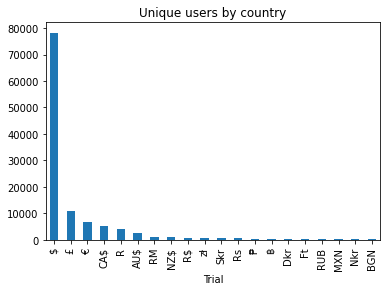

In [19]:
counts = df.groupby(['currency','user_id'])['currency'].aggregate('count')
counts.index = counts.index.set_names(['Trial', 'measurement'])
counts = counts.reset_index()
test = counts.groupby(['Trial']).size()
test.head(10)
test = test.sort_values(ascending = False)
test.head(20).plot(kind='bar',title = 'Unique users by country')

### Question 3.2 ###

<ipython-input-20-d8b1249656e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days['date_fueled'] = days['date_fueled'].dt.day_name()


<AxesSubplot:title={'center':'Unique users by day'}, xlabel='date_fueled'>

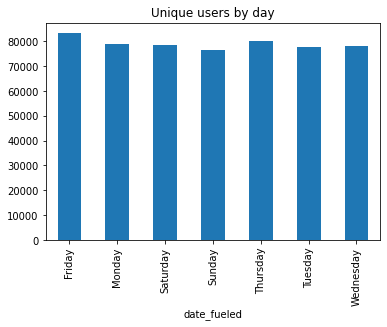

In [20]:
days = df[['date_fueled','user_id']]
days['date_fueled'] = days['date_fueled'].dt.day_name()
days = days.groupby(['date_fueled','user_id']).aggregate('count')
days.index = days.index.set_names(['date_fueled', 'user_id'])
days = days.reset_index()
test = days.groupby(['date_fueled']).size()
test.head(10)
test.plot(kind='bar',title = 'Unique users by day')

### Question 3.3 ###

age
0      21506
1      34128
2      37318
3      39083
4      39343
       ...  
97         3
98         5
100        1
102        1
103       15
Name: currency, Length: 100, dtype: int64


<AxesSubplot:xlabel='age'>

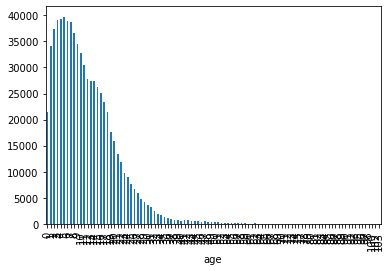

In [21]:
df['age'] = df['date_fueled'].dt.year.astype(int) - df['car_year'].astype(int) # forming age column
df = df.drop(df[df.age.astype(int) <0].index) ## Limiting ages < 0 because that doesnt make sense
counts = df.groupby(['currency','age'])['currency'].count()
dollar = counts.loc['$']
print(dollar)
dollar.plot(kind='bar')

### Question 3.4 ###

In [22]:
makes = df.groupby(['car_make'])['car_make'].count()
makes = makes.sort_values(ascending = False)
print(makes)
### BMW was most popular car brand

car_make
ford             129451
toyota           127051
bmw               98970
nissan            80587
volkswagen        69547
honda             60810
mercedes-benz     58310
audi              53510
hyundai           46763
mazda             43193
lexus             37772
kia               35894
volvo             33666
subaru            32766
jeep              31170
mitsubishi        30735
land_rover        18743
suzuki            17882
peugeot           15273
renault           14753
fiat              13752
citroen           11763
opel               9289
mini               7954
alfa_romeo         7243
isuzu              5309
tata                804
mahindra            476
Name: car_make, dtype: int64


In [23]:
makes = df.groupby(['car_model'])['car_model'].count()
makes = makes.sort_values(ascending = False)
print(makes)
### Jetta was most popular car make

car_model
civic              7459
4runner            7382
corolla            7188
f-150              7077
accord             7016
                   ... 
p-350                 1
a200d                 1
tt_rs_quattro         1
cedric                1
sprinter_marino       1
Name: car_model, Length: 2185, dtype: int64


## Question 4

### Question 4.1.1

In [24]:
#Identifying top 5 currencies
df["currency"].value_counts().nlargest(5)

$      734981
£       86031
€       58085
CA$     46115
R       35976
Name: currency, dtype: int64

### Question 4.1.2

In [25]:
dollar = df.loc[df['currency'] == '$']
pound = df.loc[df['currency'] == '£']
euro = df.loc[df['currency'] == '€']
CA_dollar = df.loc[df['currency'] == 'CA$']
rand = df.loc[df['currency'] == 'R']

initial_tally = dollar.shape[0] + pound.shape[0] + euro.shape[0] + CA_dollar.shape[0] + rand.shape[0]

<function matplotlib.pyplot.show(close=None, block=None)>

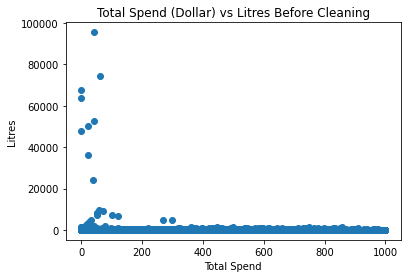

<Figure size 1080x1080 with 0 Axes>

In [26]:
plt.scatter(dollar["total_spend"], dollar["litres"])
plt.xlabel("Total Spend")
plt.ylabel("Litres")
plt.title("Total Spend (Dollar) vs Litres Before Cleaning")
plt.figure(figsize=(15,15))
plt.show

In [27]:
Q1, Q3 = dollar["total_spend"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
dollar = dollar[~(dollar["total_spend"] > UPPER )]
dollar = dollar[~(dollar["total_spend"] < 1.0)]
dollar = dollar[~(dollar["litres"] > 90)]
dollar = dollar[~(dollar["litres"] < 1.0)]
dollar = dollar[~(dollar["amount"] < 1.0)]
dollar = dollar[~(dollar["amount"] > dollar["total_spend"])]
dollar = dollar[~(dollar["mpg"] < 1.0)]

Q1, Q3 = dollar["litres"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
LOWER = Q1 - 1.5*IQR
dollar = dollar[~(dollar["litres"] > UPPER)]
dollar = dollar[~(dollar["litres"] < LOWER)]

Q1, Q3 = dollar["km_driven"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
LOWER = Q1 - 1.5*IQR
dollar = dollar[~(dollar["km_driven"] > UPPER)]
dollar = dollar[~(dollar["km_driven"] < 1)]

dollar = dollar[~(dollar["age"] > 80.0)]
dollar = dollar[~(dollar["age"] < 16.0)]

dollar = dollar.dropna()

<function matplotlib.pyplot.show(close=None, block=None)>

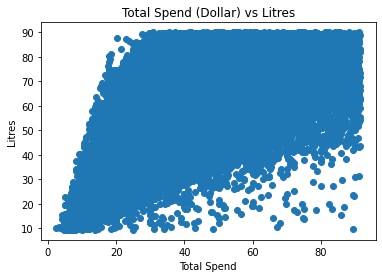

<Figure size 1080x1080 with 0 Axes>

In [28]:
plt.scatter(dollar["total_spend"], dollar["litres"])
plt.xlabel("Total Spend")
plt.ylabel("Litres")
plt.title("Total Spend (Dollar) vs Litres")
plt.figure(figsize=(15,15))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

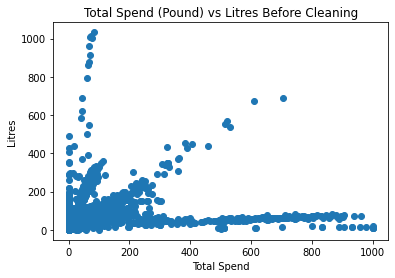

In [29]:
plt.scatter(pound["total_spend"], pound["litres"])
plt.xlabel("Total Spend")
plt.ylabel("Litres")
plt.title("Total Spend (Pound) vs Litres Before Cleaning")
plt.show

In [30]:
Q1, Q3 = pound["total_spend"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
pound = pound[~(pound["total_spend"] > UPPER )]
pound = pound[~(pound["total_spend"] < 1.0)]
pound = pound[~(pound["litres"] > 90)]
pound = pound[~(pound["litres"] < 1.0)]
pound = pound[~(pound["amount"] < 1.0)]
pound = pound[~(pound["amount"] > pound["total_spend"])]
pound = pound[~(pound["mpg"] < 1.0)]

Q1, Q3 = pound["litres"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
LOWER = Q1 - 1.5*IQR
pound = pound[~(pound["litres"] > UPPER)]
pound = pound[~(pound["litres"] < LOWER)]

Q1, Q3 = pound["km_driven"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
LOWER = Q1 - 1.5*IQR
pound = pound[~(pound["km_driven"] > UPPER)]
pound = pound[~(pound["km_driven"] < 1)]

pound = pound[~(pound["age"] > 80.0)]
pound = pound[~(pound["age"] < 17.0)]

pound = pound.dropna()

<function matplotlib.pyplot.show(close=None, block=None)>

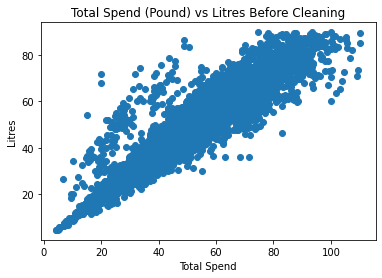

In [31]:
plt.scatter(pound["total_spend"], pound["litres"])
plt.xlabel("Total Spend")
plt.ylabel("Litres")
plt.title("Total Spend (Pound) vs Litres Before Cleaning")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

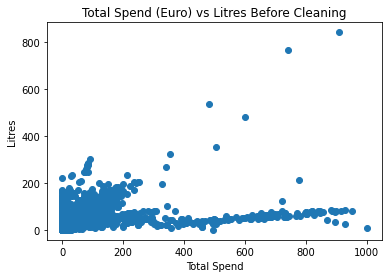

In [32]:
plt.scatter(euro["total_spend"], euro["litres"])
plt.xlabel("Total Spend")
plt.ylabel("Litres")
plt.title("Total Spend (Euro) vs Litres Before Cleaning")
plt.show

In [33]:
Q1, Q3 = euro["total_spend"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
euro = euro[~(euro["total_spend"] > UPPER )]
euro = euro[~(euro["total_spend"] < 1.0)]
euro = euro[~(euro["litres"] > 90)]
euro = euro[~(euro["litres"] < 1.0)]
euro = euro[~(euro["amount"] < 1.0)]
euro = euro[~(euro["amount"] > euro["total_spend"])]
euro = euro[~(euro["mpg"] < 1.0)]

Q1, Q3 = euro["litres"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
LOWER = Q1 - 1.5*IQR
euro = euro[~(euro["litres"] > UPPER)]
euro = euro[~(euro["litres"] < LOWER)]

Q1, Q3 = euro["km_driven"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
LOWER = Q1 - 1.5*IQR
euro = euro[~(euro["km_driven"] > UPPER)]
euro = euro[~(euro["km_driven"] < 1)]

euro = euro[~(euro["age"] > 80.0)]
euro = euro[~(euro["age"] < 18.0)] #Used the minimum for the European Union

euro = euro.dropna()

<function matplotlib.pyplot.show(close=None, block=None)>

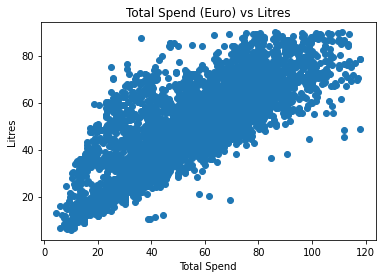

In [34]:
plt.scatter(euro["total_spend"], euro["litres"])
plt.xlabel("Total Spend")
plt.ylabel("Litres")
plt.title("Total Spend (Euro) vs Litres")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

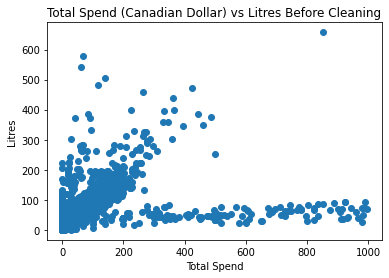

In [35]:
plt.scatter(CA_dollar["total_spend"], CA_dollar["litres"])
plt.xlabel("Total Spend")
plt.ylabel("Litres")
plt.title("Total Spend (Canadian Dollar) vs Litres Before Cleaning")
plt.show

In [36]:
Q1, Q3 = CA_dollar["total_spend"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
CA_dollar = CA_dollar[~(CA_dollar["total_spend"] > UPPER )]
CA_dollar = CA_dollar[~(CA_dollar["total_spend"] < 1.0)]
CA_dollar = CA_dollar[~(CA_dollar["litres"] > 90)]
CA_dollar = CA_dollar[~(CA_dollar["litres"] < 1.0)]
CA_dollar = CA_dollar[~(CA_dollar["amount"] < 1.0)]
CA_dollar = CA_dollar[~(CA_dollar["amount"] > CA_dollar["total_spend"])]
CA_dollar = CA_dollar[~(CA_dollar["mpg"] < 1.0)]

Q1, Q3 = CA_dollar["litres"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
LOWER = Q1 - 1.5*IQR
CA_dollar = CA_dollar[~(CA_dollar["litres"] > UPPER)]
CA_dollar = CA_dollar[~(CA_dollar["litres"] < LOWER)]

Q1, Q3 = CA_dollar["km_driven"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
LOWER = Q1 - 1.5*IQR
CA_dollar = CA_dollar[~(CA_dollar["km_driven"] > UPPER)]
CA_dollar = CA_dollar[~(CA_dollar["km_driven"] < 1)]

CA_dollar = CA_dollar[~(CA_dollar["age"] > 80.0)]
CA_dollar = CA_dollar[~(CA_dollar["age"] < 16.0)]

CA_dollar = CA_dollar.dropna()

<function matplotlib.pyplot.show(close=None, block=None)>

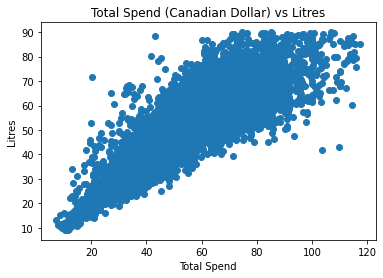

In [37]:
plt.scatter(CA_dollar["total_spend"], CA_dollar["litres"])
plt.xlabel("Total Spend")
plt.ylabel("Litres")
plt.title("Total Spend (Canadian Dollar) vs Litres")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

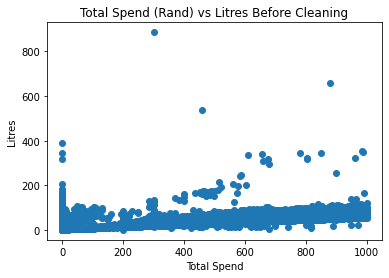

In [38]:
plt.scatter(rand["total_spend"], rand["litres"])
plt.xlabel("Total Spend")
plt.ylabel("Litres")
plt.title("Total Spend (Rand) vs Litres Before Cleaning")
plt.show

In [39]:
Q1, Q3 = rand["total_spend"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
rand = rand[~(rand["total_spend"] > UPPER )]
rand = rand[~(rand["total_spend"] < 1.0)]
rand = rand[~(rand["litres"] > 90)]
rand = rand[~(rand["litres"] < 1.0)]
rand = rand[~(rand["amount"] < 1.0)]
rand = rand[~(rand["amount"] > rand["total_spend"])]
rand = rand[~(rand["mpg"] < 1.0)]

Q1, Q3 = rand["litres"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
LOWER = Q1 - 1.5*IQR
rand = rand[~(rand["litres"] > UPPER)]
rand = rand[~(rand["litres"] < LOWER)]

Q1, Q3 = rand["km_driven"].quantile([0.25, 0.75])
IQR = Q3 - Q1
UPPER = 1.5*IQR + Q3
LOWER = Q1 - 1.5*IQR
rand = rand[~(rand["km_driven"] > UPPER)]
rand = rand[~(rand["km_driven"] < 1)]

rand = rand[~(rand["age"] > 80.0)]
rand = rand[~(rand["age"] < 18.0)]

rand = rand.dropna()

<function matplotlib.pyplot.show(close=None, block=None)>

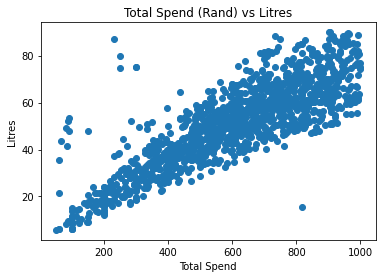

In [40]:
plt.scatter(rand["total_spend"], rand["litres"])
plt.xlabel("Total Spend")
plt.ylabel("Litres")
plt.title("Total Spend (Rand) vs Litres")
plt.show

The approach to removing outliers was:

1. Calculating the interquartile range and multiplying it by 1.5, and thereafter adding it to the third quartile (Q3) or subtracting it from the first quartile (Q1) to obtain the UPPER or LOWER limits which were used to remove outliers. They were used for the following: "total_spend", "litres", and "km_driven".

2. The average fuel tank capacity is around 45 litres for vehicles and around 80 litres for 4x4's. We assumed that the drivers did not drive a vehicle larger than a 4x4 so we assumed the maximum fuel tank size to be 90 litres (assuming 10 litres is the reserve).

3. Values that were less than 1 were removed from certain columns. This was done as it is trivial to be filling less than a gallon of fuel at a filling station for instance.

4. The values from the column "amount" was compared to "total_spend" and values where the "amount" was greater than the "total_spend" were dropped since "amount" $\le$ "total_spend".

5. Anyone below the minimum age to legally drive in the country or region was dropped, and people older than the age of 80 were removed as they should be collecting pension instead of driving.

6. Lastly, null values were removed.

It is apparent that not all outliers were removed, but the data is much cleaner.

In [41]:
top5 = [dollar, pound, euro, CA_dollar, rand]
data = pd.concat(top5)

### Question 4.1.3

In [42]:
print(str(initial_tally - data.shape[0]) + " values have been removed.\n" + "Overall " + str(df_tally - data.shape[0]) + " values have been removed.")

814898 values have been removed.
Overall 1028580 values have been removed.


### Question 4.2.1

[SARS Average Exchange Rates](https://www.sars.gov.za/wp-content/uploads/Legal/Rates/LAPD-Pub-AER-2012-02-Average-Exchange-Rates-Table-A.pdf) were used to convert the respective currencies to Rands - the average price for January 2022 was used. These were the values obtained and will be used to convert the currencies to ZAR (rounded to two decimal places):
- 1 USD to ZAR = R14.85
- 1 GBP to ZAR = R20.37
- 1 EUR to ZAR = R17.41
- 1 CAD to ZAR = R11.82

country
Canada            14.596094
Eurozone          21.387531
South Africa      15.623029
USA               11.748630
United Kingdom    24.638802
Name: cost_per_litre, dtype: float64


<AxesSubplot:title={'center':'Average Price of Fuel per Litre in January 2022'}, xlabel='country', ylabel='Average Price in ZAR'>

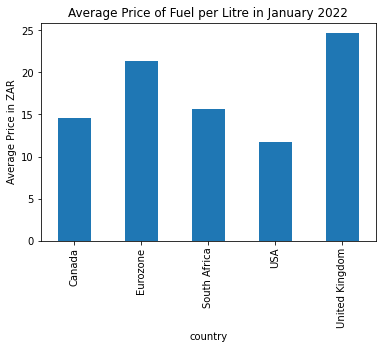

In [47]:
dollar["zar_amount"] = dollar["amount"] * 14.85
pound["zar_amount"] = pound["amount"] * 20.37
euro["zar_amount"] = euro["amount"] * 17.41
CA_dollar["zar_amount"] = CA_dollar["amount"] * 11.82
rand["zar_amount"] = rand["amount"]

dollar["cost_per_litre"] =  np.round(dollar["zar_amount"] /  4.54609, 3)
pound["cost_per_litre"] = np.round(pound["zar_amount"] /  4.54609, 3)
euro["cost_per_litre"] = np.round(euro["zar_amount"] /  4.54609, 3)
CA_dollar["cost_per_litre"] = np.round(CA_dollar["zar_amount"] /  4.54609, 3)
rand["cost_per_litre"] = np.round(rand["zar_amount"] /  4.54609, 3)

dollar["country"] =  "USA"
pound["country"] = "United Kingdom"
euro["country"] = "Eurozone"
CA_dollar["country"] = "Canada"
rand["country"] = "South Africa"

top5 = [dollar, pound, euro, CA_dollar, rand]
top5_currencies = pd.concat(top5)

data = top5_currencies

jan_mask = (top5_currencies["date_fueled"].dt.year == 2022) & (top5_currencies["date_fueled"].dt.month < 2)
top5_currencies = top5_currencies[jan_mask]
top5_currencies = top5_currencies.reset_index(drop = True)

#data = top5_currencies

jan_currencies = top5_currencies.groupby(top5_currencies.country)["cost_per_litre"].mean()
print(jan_currencies)
jan_currencies.plot(kind = "bar", title = "Average Price of Fuel per Litre in January 2022", ylabel = "Average Price in ZAR")

Factors that influence the price of fuel could be whther the country has their own fuel reserves which will make the cost cheaper than other countries, and the price they pay for importing it into country, among other factors. Notably, the Euro is used in countries part of the Eurozone, and since we have no insight as to which countries we are dealing with beyond currencies, it reasonable to assume it is the average price of fuel in the Eurozone (albeit not a true representation).

### Question 4.2.2

In [48]:
data['odometer'] = data['odometer'].replace(',','', regex=True).astype(float)
data = data.sort_values(by = "user_id")
data = data.reset_index(drop = True)
data.head()

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency,...,car_model,car_year,user_id,litres,km_driven,litres_per_100km,age,zar_amount,cost_per_litre,country
0,2021-02-07,Feb 9 2021,104824.0,9.272,$2.199,$20.39,23.1,214.1832,https://www.somewebsite.com/volkswagen/fox/198...,$,...,fox,1988,1000007,42.151346,344.693591,8.177523,33,32.65515,7.183,USA
1,2020-07-19,Jul 19 2020,187376.0,15.949,$3.249,$51.82,16.4,261.5636,https://www.somewebsite.com/nissan/frontier/20...,$,...,frontier,2003,1000031,72.505589,420.944764,5.805687,17,48.24765,10.613,USA
2,2020-08-04,Aug 4 2020,187898.0,16.631,$2.879,$47.88,16.1,267.7591,https://www.somewebsite.com/nissan/frontier/20...,$,...,frontier,2003,1000031,75.606023,430.915430,5.699485,17,42.75315,9.404,USA
3,2020-11-16,Nov 23 2020,190703.0,16.192,$3.299,$53.42,16.2,262.3104,https://www.somewebsite.com/nissan/frontier/20...,$,...,frontier,2003,1000031,73.610289,422.146619,5.734886,17,48.99015,10.776,USA
4,2020-04-27,Apr 27 2020,185652.0,13.640,$2.459,$33.54,18.4,250.9760,https://www.somewebsite.com/nissan/frontier/20...,$,...,frontier,2003,1000031,62.008668,403.905716,6.513698,17,36.51615,8.032,USA


In [49]:
count = 0 

odometer = data["odometer"].to_numpy()
miles = data["miles"].to_numpy()
user_id = data["user_id"].to_numpy()

for i in range (2, data.shape[0]):
    if user_id[i - 1] == user_id[i]:
        if np.floor(miles[i - 1]) + odometer[i - 1] != odometer[i]:
            count += 1
        else:
            pass
    else:
        pass
    
print("There approxiamately " + str(count) + " instances where users missed logging between fuel ups.")

There approxiamately 123911 instances where users missed logging between fuel ups.


Since the miles gives the total number of miles driven on the tank of fuel and the odometer is the reading at the time of refueling, the odometer at the next refueling should be miles + odometer from the previous refueling. If it is not the case we may assume that a refuel was not logged.

### Question 4.2.3

country
Canada             7.539721
Eurozone          10.357419
South Africa       8.068146
USA                7.319107
United Kingdom     9.385878
Name: litres_per_100km, dtype: float64


<AxesSubplot:title={'center':'Average Distance per Tank per Country'}, xlabel='country', ylabel='Average Distance per Tank'>

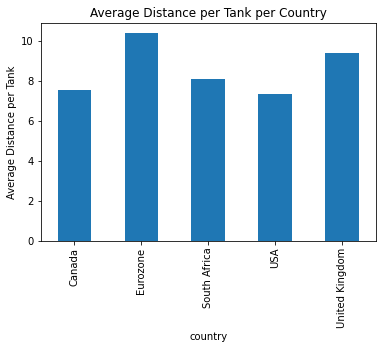

In [50]:
average_distance = data.groupby(data.country)["litres_per_100km"].mean()
print(average_distance)
average_distance.plot(kind = "bar", title = "Average Distance per Tank per Country", ylabel = "Average Distance per Tank")

The above actually gives the average distance (km) per litre of fuel but the same inferences can be made. The reason there could be a disparity is due to the types of cars driven in these countries - for instance, cars in the Eurozone may be more fuel efficient and environentally friendly, whereas in the USA, people may drive cars with bigger engines that are less fuel efficient and less evironemntally friendly.

### Question 4.2.4

<AxesSubplot:xlabel='car_year'>

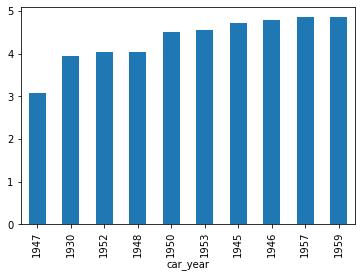

In [51]:
years = data.groupby(['car_year'])['litres_per_100km'].aggregate('mean')
years = years.sort_values(ascending = True)
years.head(10).plot(kind="bar")

# No, newer cars do not mean better efficiency

### Question 4.2.5

In [52]:
top_5_sa = data.loc[data['currency'] == "R"]
top_5_sa = top_5_sa.groupby(['car_model'])['car_model'].aggregate('count')
top_5_sa = top_5_sa.sort_values(ascending = False)
print(top_5_sa.head(5))

x_trail = data.loc[(data['currency'] == "R") & (data['car_model'] == "x-trail")]
corsa = data.loc[(data['currency'] == "R") & (data['car_model'] == "corsa")]
hilux = data.loc[(data['currency'] == "R") & (data['car_model'] == "hilux")]
m3 = data.loc[(data['currency'] == "R") & (data['car_model'] == "m3")]
a4 = data.loc[(data['currency'] == "R") & (data['car_model'] == "a4")]

print("X-Trail : ",round(x_trail["litres_per_100km"].mean(),2))
print("Corsa : ",round(corsa["litres_per_100km"].mean(),2))
print("Hilux : ",round(hilux["litres_per_100km"].mean(),2))
print("M3 : ",round(m3["litres_per_100km"].mean(),2))
print("A4 : ",round(a4["litres_per_100km"].mean(),2))

# I personally think some of these values are realistic and some are not. 
# For example, a corsa being the most popular car in SA, has the worst fuel efficiency
# The rest of the values seem realistic

car_model
jetta      57
corolla    56
hilux      52
golf       43
pajero     42
Name: car_model, dtype: int64
X-Trail :  8.45
Corsa :  9.69
Hilux :  5.63
M3 :  6.35
A4 :  7.58


### Question 4.2.6

In [53]:
# https://www.consumerreports.org/fuel-economy-efficiency/best-worst-fuel-economy-a3183445363/
# filtration applied to 5 litres/100 because that seems realistic enough 

top_5 = data.loc[data['currency'] == "$"]
top_5 = top_5.groupby(['car_model']).agg({'litres_per_100km': ['mean']}).reset_index()
top_5 = top_5.sort_values(('litres_per_100km','mean'),ascending = True)
top_5['litres_per_100km','mean'] = pd.to_numeric(top_5['litres_per_100km','mean'],errors='coerce')

print("US",top_5.loc[top_5['litres_per_100km','mean'] > 5].head(10))

top_5 = data.loc[data['currency'] == "R"]
top_5 = top_5.groupby(['car_model']).agg({'litres_per_100km': ['mean']}).reset_index()
top_5 = top_5.sort_values(('litres_per_100km','mean'),ascending = True)
top_5['litres_per_100km','mean'] = pd.to_numeric(top_5['litres_per_100km','mean'],errors='coerce')

print("SA",top_5.loc[top_5['litres_per_100km','mean'] > 5].head(10))

top_5 = data.loc[data['currency'] == "£"]
top_5 = top_5.groupby(['car_model']).agg({'litres_per_100km': ['mean']}).reset_index()
top_5 = top_5.sort_values(('litres_per_100km','mean'),ascending = True)
top_5['litres_per_100km','mean'] = pd.to_numeric(top_5['litres_per_100km','mean'],errors='coerce')

print("UK",top_5.loc[top_5['litres_per_100km','mean'] > 5].head(10))

top_5 = data.loc[data['currency'] == "€"]
top_5 = top_5.groupby(['car_model']).agg({'litres_per_100km': ['mean']}).reset_index()
top_5 = top_5.sort_values(('litres_per_100km','mean'),ascending = True)
top_5['litres_per_100km','mean'] = pd.to_numeric(top_5['litres_per_100km','mean'],errors='coerce')

print("Europe",top_5.loc[top_5['litres_per_100km','mean'] > 5].head(10))

top_5 = data.loc[data['currency'] == "CA$"]
top_5 = top_5.groupby(['car_model']).agg({'litres_per_100km': ['mean']}).reset_index()
top_5 = top_5.sort_values(('litres_per_100km','mean'),ascending = True)
top_5['litres_per_100km','mean'] = pd.to_numeric(top_5['litres_per_100km','mean'],errors='coerce')

print("Canada",top_5.loc[top_5['litres_per_100km','mean'] > 5].head(10))

US            car_model litres_per_100km
                                 mean
737         wrangler         5.013114
517            ml500         5.015350
426   grand_cherokee         5.028773
192               a8         5.062276
638          sequoia         5.073788
332  e-150_econoline         5.077402
702               tj         5.082647
178              929         5.097676
726        vehicross         5.107264
715           tundra         5.120262
SA         car_model litres_per_100km
                              mean
110        sj_410         5.026875
80          ls400         5.218038
55   discovery_ii         5.239279
54      discovery         5.451682
95          prado         5.478913
13           280e         5.487082
84        montero         5.575584
121       trooper         5.589351
115         supra         5.593284
77   land_cruiser         5.593284
UK        car_model litres_per_100km
                             mean
58           745         5.097676
48           

### Question 4.2.7

Canada top 5 vehicles car_model
122      15
190e     25
200sx    10
240      42
240sx    10
Name: car_model, dtype: int64
146290


<function matplotlib.pyplot.show(close=None, block=None)>

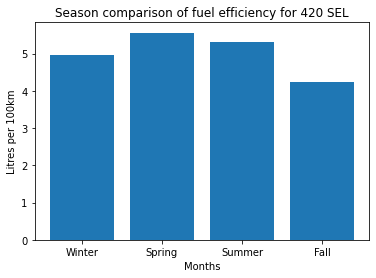

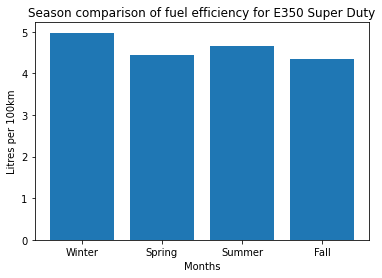

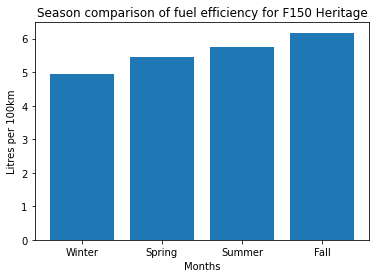

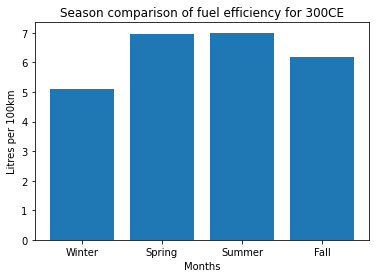

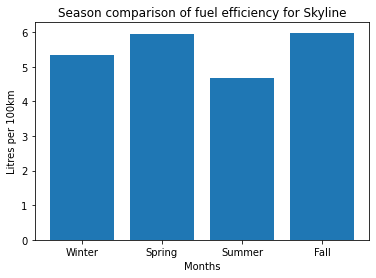

In [54]:
top_5 = data.loc[data['currency'] == "CA$"]
top_5 = top_5.groupby(['car_model'])['car_model'].aggregate('count')
print("Canada top 5 vehicles",top_5.head(5))

# Top 5 most fuel efficient vehicles in Canada are : 420sel, e-350_super_duty, f-150_heritage, 300ce and skyline
print(len(data))
means = []
month_subset = data.loc[(data['date_fueled'].dt.month == 12) | (data['date_fueled'].dt.month == 1) | (data['date_fueled'].dt.month == 2)]
month_subset = month_subset.loc[data['car_model'] == "420sel"]
mean_winter = month_subset['litres_per_100km'].mean()
means.append(mean_winter)

month_subset = data.loc[(data['date_fueled'].dt.month == 3) | (data['date_fueled'].dt.month == 4) | (data['date_fueled'].dt.month == 5)]
month_subset = month_subset.loc[data['car_model'] == "420sel"]
mean_spring = month_subset['litres_per_100km'].mean()
means.append(mean_spring)

month_subset = data.loc[(data['date_fueled'].dt.month == 6) | (data['date_fueled'].dt.month == 7) | (data['date_fueled'].dt.month == 8)]
month_subset = month_subset.loc[data['car_model'] == "420sel"]
mean_summer = month_subset['litres_per_100km'].mean()
means.append(mean_summer)

month_subset = data.loc[(data['date_fueled'].dt.month == 9) | (data['date_fueled'].dt.month == 10) | (data['date_fueled'].dt.month == 11)]
month_subset = month_subset.loc[data['car_model'] == "420sel"]
mean_fall = month_subset['litres_per_100km'].mean()
means.append(mean_fall)

plt.figure(1)
plt.bar(["Winter","Spring","Summer","Fall"],means)
plt.xlabel("Months")
plt.ylabel("Litres per 100km")
plt.title("Season comparison of fuel efficiency for 420 SEL")

means = []
month_subset = data.loc[(data['date_fueled'].dt.month == 12) | (data['date_fueled'].dt.month == 1) | (data['date_fueled'].dt.month == 2)]
month_subset = month_subset.loc[data['car_model'] == "e-350_super_duty"]
mean_winter = month_subset['litres_per_100km'].mean()
means.append(mean_winter)

month_subset = data.loc[(data['date_fueled'].dt.month == 3) | (data['date_fueled'].dt.month == 4) | (data['date_fueled'].dt.month == 5)]
month_subset = month_subset.loc[data['car_model'] == "e-350_super_duty"]
mean_spring = month_subset['litres_per_100km'].mean()
means.append(mean_spring)

month_subset = data.loc[(data['date_fueled'].dt.month == 6) | (data['date_fueled'].dt.month == 7) | (data['date_fueled'].dt.month == 8)]
month_subset = month_subset.loc[data['car_model'] == "e-350_super_duty"]
mean_summer = month_subset['litres_per_100km'].mean()
means.append(mean_summer)

month_subset = data.loc[(data['date_fueled'].dt.month == 9) | (data['date_fueled'].dt.month == 10) | (data['date_fueled'].dt.month == 11)]
month_subset = month_subset.loc[data['car_model'] == "e-350_super_duty"]
mean_fall = month_subset['litres_per_100km'].mean()
means.append(mean_fall)

plt.figure(2)
plt.bar(["Winter","Spring","Summer","Fall"],means)
plt.xlabel("Months")
plt.ylabel("Litres per 100km")
plt.title("Season comparison of fuel efficiency for E350 Super Duty")

means = []
month_subset = data.loc[(data['date_fueled'].dt.month == 12) | (data['date_fueled'].dt.month == 1) | (data['date_fueled'].dt.month == 2)]
month_subset = month_subset.loc[data['car_model'] == "f-150_heritage"]
mean_winter = month_subset['litres_per_100km'].mean()
means.append(mean_winter)

month_subset = data.loc[(data['date_fueled'].dt.month == 3) | (data['date_fueled'].dt.month == 4) | (data['date_fueled'].dt.month == 5)]
month_subset = month_subset.loc[data['car_model'] == "f-150_heritage"]
mean_spring = month_subset['litres_per_100km'].mean()
means.append(mean_spring)

month_subset = data.loc[(data['date_fueled'].dt.month == 6) | (data['date_fueled'].dt.month == 7) | (data['date_fueled'].dt.month == 8)]
month_subset = month_subset.loc[data['car_model'] == "f-150_heritage"]
mean_summer = month_subset['litres_per_100km'].mean()
means.append(mean_summer)

month_subset = data.loc[(data['date_fueled'].dt.month == 9) | (data['date_fueled'].dt.month == 10) | (data['date_fueled'].dt.month == 11)]
month_subset = month_subset.loc[data['car_model'] == "f-150_heritage"]
mean_fall = month_subset['litres_per_100km'].mean()
means.append(mean_fall)

plt.figure(3)
plt.bar(["Winter","Spring","Summer","Fall"],means)
plt.xlabel("Months")
plt.ylabel("Litres per 100km")
plt.title("Season comparison of fuel efficiency for F150 Heritage")

means = []
month_subset = data.loc[(data['date_fueled'].dt.month == 12) | (data['date_fueled'].dt.month == 1) | (data['date_fueled'].dt.month == 2)]
month_subset = month_subset.loc[data['car_model'] == "300ce"]
mean_winter = month_subset['litres_per_100km'].mean()
means.append(mean_winter)

month_subset = data.loc[(data['date_fueled'].dt.month == 3) | (data['date_fueled'].dt.month == 4) | (data['date_fueled'].dt.month == 5)]
month_subset = month_subset.loc[data['car_model'] == "300ce"]
mean_spring = month_subset['litres_per_100km'].mean()
means.append(mean_spring)

month_subset = data.loc[(data['date_fueled'].dt.month == 6) | (data['date_fueled'].dt.month == 7) | (data['date_fueled'].dt.month == 8)]
month_subset = month_subset.loc[data['car_model'] == "300ce"]
mean_summer = month_subset['litres_per_100km'].mean()
means.append(mean_summer)

month_subset = data.loc[(data['date_fueled'].dt.month == 9) | (data['date_fueled'].dt.month == 10) | (data['date_fueled'].dt.month == 11)]
month_subset = month_subset.loc[data['car_model'] == "300ce"]
mean_fall = month_subset['litres_per_100km'].mean()
means.append(mean_fall)

plt.figure(4)
plt.bar(["Winter","Spring","Summer","Fall"],means)
plt.xlabel("Months")
plt.ylabel("Litres per 100km")
plt.title("Season comparison of fuel efficiency for 300CE")

means = []
month_subset = data.loc[(data['date_fueled'].dt.month == 12) | (data['date_fueled'].dt.month == 1) | (data['date_fueled'].dt.month == 2)]
month_subset = month_subset.loc[data['car_model'] == "skyline"]
mean_winter = month_subset['litres_per_100km'].mean()
means.append(mean_winter)

month_subset = data.loc[(data['date_fueled'].dt.month == 3) | (data['date_fueled'].dt.month == 4) | (data['date_fueled'].dt.month == 5)]
month_subset = month_subset.loc[data['car_model'] == "skyline"]
mean_spring = month_subset['litres_per_100km'].mean()
means.append(mean_spring)

month_subset = data.loc[(data['date_fueled'].dt.month == 6) | (data['date_fueled'].dt.month == 7) | (data['date_fueled'].dt.month == 8)]
month_subset = month_subset.loc[data['car_model'] == "skyline"]
mean_summer = month_subset['litres_per_100km'].mean()
means.append(mean_summer)

month_subset = data.loc[(data['date_fueled'].dt.month == 9) | (data['date_fueled'].dt.month == 10) | (data['date_fueled'].dt.month == 11)]
month_subset = month_subset.loc[data['car_model'] == "skyline"]
mean_fall = month_subset['litres_per_100km'].mean()
means.append(mean_fall)

plt.figure(5)
plt.bar(["Winter","Spring","Summer","Fall"],means)
plt.xlabel("Months")
plt.ylabel("Litres per 100km")
plt.title("Season comparison of fuel efficiency for Skyline")
plt.show

### Question 4.2.8

<AxesSubplot:>

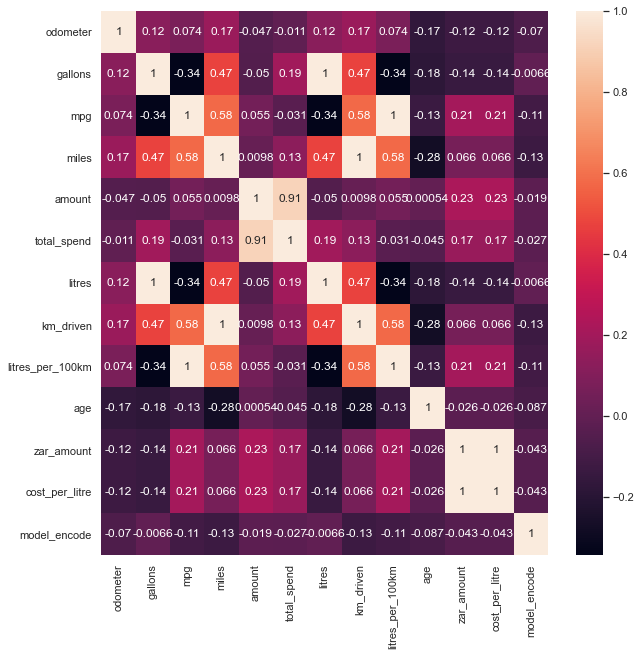

In [55]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
data["model_encode"] = ord_enc.fit_transform(data[["car_model"]])

sns.set(rc = {'figure.figsize':(10,10)}) #Size of heatmap
sns.heatmap(data.corr(), annot=True)

### Question 4.2.9

          Features  Importances
5        car_model     0.312732
2         odometer     0.112477
4         car_make     0.109815
0      date_fueled     0.087261
7          user_id     0.069290
6         car_year     0.057751
3         currency     0.057413
1    date_captured     0.051336
10  cost_per_litre     0.048099
9       zar_amount     0.047919
8              age     0.042683
11         country     0.003223


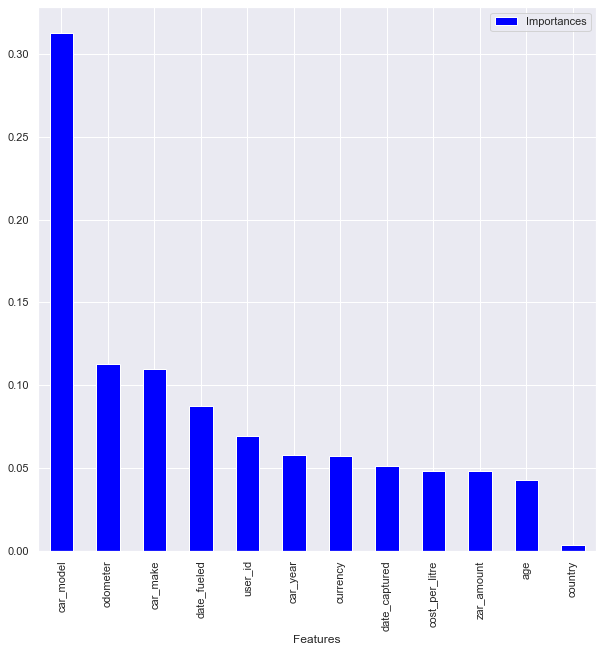

In [56]:
data['odometer'] = data['odometer'].replace(',','', regex=True)
subset = data.loc[:, (data.columns != 'cost_per_gallon') & (data.columns != 'gallons') 
                  & (data.columns != 'total_spent') & (data.columns != 'litres_per_100km')  
                  & (data.columns != 'mpg') & (data.columns != 'user_url') & (data.columns != 'amount') 
                  & (data.columns != 'total_spend') & (data.columns != 'litres') & (data.columns != 'km_driven')
                  & (data.columns != 'miles') & (data.columns != 'model_encode')]
subset = subset.apply(LabelEncoder().fit_transform)
X_train,X_test,y_train,y_test = train_test_split(subset,data['litres_per_100km'],test_size=0.3)

sel = RandomForestRegressor(n_estimators = 100)
sel.fit(X_train, y_train)
importances = sel.feature_importances_

final_df = pd.DataFrame({ "Features": pd.DataFrame(X_train).columns, "Importances": importances})
final_df.set_index('Importances')
final_df = final_df.sort_values('Importances', ascending = False)
final_df.plot.bar(color='blue', x='Features')
print(final_df)

# Most important variable is car_model. With other important ones being car_make, odometer, date_captured and user_id
# They are not that different from each other. Car_make and car_model are related to each other. Odometer is related to the age
# which makes sense as well. Older the car, the higher odometer.
# They relate strongly to the variables from the correlations above

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146290 entries, 0 to 146289
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date_fueled       146290 non-null  datetime64[ns]
 1   date_captured     146290 non-null  object        
 2   odometer          146290 non-null  float64       
 3   gallons           146290 non-null  float64       
 4   cost_per_gallon   146290 non-null  object        
 5   total_spent       146290 non-null  object        
 6   mpg               146290 non-null  float64       
 7   miles             146290 non-null  float64       
 8   user_url          146290 non-null  object        
 9   currency          146290 non-null  object        
 10  amount            146290 non-null  float64       
 11  total_spend       146290 non-null  float64       
 12  car_make          146290 non-null  object        
 13  car_model         146290 non-null  object        
 14  car_

### Question 4.3.1

In [58]:
#Data was previously filtered
rand.head()

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency,...,car_model,car_year,user_id,litres,km_driven,litres_per_100km,age,zar_amount,cost_per_litre,country
1417,2021-01-24,Jan 24 2021,"157,307",16.791,R53.60,R900.01,7.6,127.6116,https://www.somewebsite.com/mitsubishi/pajero/...,R,...,pajero,1999,976487,76.333397,205.370452,2.690440,22,53.60,11.790,South Africa
1844,2012-10-17,Oct 17 2012,"71,347",9.854,R45.42,R447.62,18.3,180.3282,https://www.somewebsite.com/volkswagen/golf/19...,R,...,golf,1993,81434,44.797171,290.209385,6.478297,19,45.42,9.991,South Africa
2685,2017-01-02,Sep 21 2018,"211,265",16.558,R44.29,R733.36,28.1,465.2798,https://www.somewebsite.com/isuzu/kb280dt/1997...,R,...,kb280dt,1997,851105,75.274158,748.793393,9.947549,20,44.29,9.742,South Africa
3439,2021-01-17,Jan 17 2021,"203,580",13.224,R54.78,R724.37,13.3,175.8792,https://www.somewebsite.com/land_rover/discove...,R,...,discovery,2000,944396,60.117494,283.049432,4.708271,21,54.78,12.050,South Africa
3630,2019-11-21,Nov 21 2019,"117,057",13.280,R61.63,R818.40,18.5,245.6800,https://www.somewebsite.com/opel/astra/1997/71...,R,...,astra,1997,715061,60.372075,395.382651,6.549098,22,61.63,13.557,South Africa


### Question 4.3.2

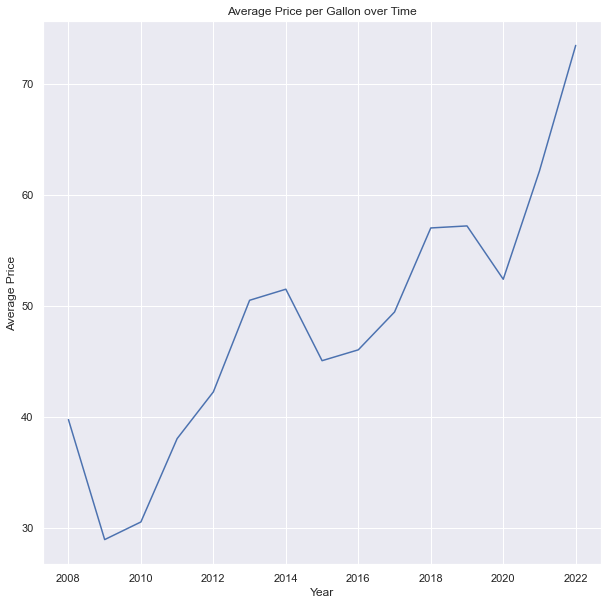

In [59]:
plt.plot(rand.groupby(rand.date_fueled.dt.year)["amount"].mean())
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.title("Average Price per Gallon over Time")
plt.show()

### Question 4.3.3

In [60]:
rand["day_of_week"] = rand["date_fueled"].dt.day_name()

### Question 4.3.4

<AxesSubplot:title={'center':'Number of people fueling on other days of week vs Tuesday'}>

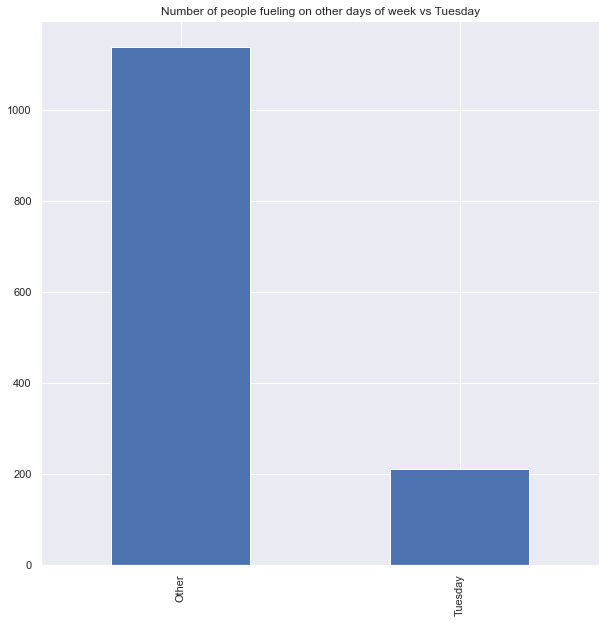

In [61]:
rand["tuesday"] = rand["day_of_week"]
rand["tuesday"] = np.where(rand["tuesday"].isin(["Tuesday"]), rand.tuesday, "Other")
tuesday = rand["tuesday"].value_counts()
tuesday.plot(kind = "bar", title = "Number of people fueling on other days of week vs Tuesday")

### Question 4.3.5

In [62]:
tue_mask = (rand["date_fueled"].dt.weekday == 1) & (rand["date_fueled"].dt.day < 8)
wed_mask = (rand["date_fueled"].dt.weekday == 2) & (rand["date_fueled"].dt.day < 8)
rand = rand[tue_mask | wed_mask]
rand = rand.sort_values(by="date_fueled")
rand.reset_index(drop=True)

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency,...,user_id,litres,km_driven,litres_per_100km,age,zar_amount,cost_per_litre,country,day_of_week,tuesday
0,2009-10-06,Oct 6 2009,"196,148",9.156,R29.60,R271.04,28.4,260.0304,https://www.somewebsite.com/volkswagen/passat/...,R,...,19969,41.624000,418.477324,10.053751,35,29.60,6.511,South Africa,Tuesday,Tuesday
1,2010-06-02,Aug 5 2011,"111,317",10.732,R31.08,R333.53,19.6,210.3472,https://www.somewebsite.com/volkswagen/jetta/1...,R,...,84693,48.788638,338.520163,6.938504,21,31.08,6.837,South Africa,Wednesday,Other
2,2011-12-06,May 5 2012,"696,940",14.445,R39.56,R571.42,2.9,41.8905,https://www.somewebsite.com/nissan/1tonnerdc/1...,R,...,109057,65.668270,67.416057,1.026615,24,39.56,8.702,South Africa,Tuesday,Tuesday
3,2012-01-03,Jan 3 2012,"129,137",17.792,R39.71,R706.50,18.7,332.7104,https://www.somewebsite.com/alfa_romeo/giuliet...,R,...,100147,80.884033,535.444155,6.619899,27,39.71,8.735,South Africa,Tuesday,Tuesday
4,2012-08-01,Dec 17 2012,"7,359",2.474,R40.43,R100.02,38.4,95.0016,https://www.somewebsite.com/suzuki/samurai/198...,R,...,168261,11.247027,152.889875,13.593804,26,40.43,8.893,South Africa,Wednesday,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-03-01,Mar 1 2022,"148,936",8.601,R73.51,R632.32,21.8,187.5018,https://www.somewebsite.com/audi/a4/2003/536116,R,...,536116,39.100920,301.754147,7.717316,19,73.51,16.170,South Africa,Tuesday,Tuesday
119,2022-03-01,Mar 2 2022,"288,024",4.984,R76.24,R380.00,2.4,11.9616,https://www.somewebsite.com/opel/corsa/2004/99...,R,...,997919,22.657713,19.250281,0.849613,18,76.24,16.770,South Africa,Tuesday,Tuesday
120,2022-03-01,Mar 1 2022,"146,220",10.997,R75.03,R825.11,27.9,306.8163,https://www.somewebsite.com/toyota/camry/1995/...,R,...,780797,49.993352,493.771744,9.876748,27,75.03,16.504,South Africa,Tuesday,Tuesday
121,2022-03-02,Mar 2 2022,"123,997",7.566,R73.51,R556.19,21.1,159.6426,https://www.somewebsite.com/opel/corsa/1998/10...,R,...,1093284,34.395717,256.919222,7.469512,24,73.51,16.170,South Africa,Wednesday,Other


### Question 4.3.6

In [63]:
#Using the average price to get an indicator since there are multiple entries for the same days
rand["average_price_per_day"] = rand.groupby(rand.date_fueled)["amount"].transform("mean")
rand.reset_index(drop=True)

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency,...,litres,km_driven,litres_per_100km,age,zar_amount,cost_per_litre,country,day_of_week,tuesday,average_price_per_day
0,2009-10-06,Oct 6 2009,"196,148",9.156,R29.60,R271.04,28.4,260.0304,https://www.somewebsite.com/volkswagen/passat/...,R,...,41.624000,418.477324,10.053751,35,29.60,6.511,South Africa,Tuesday,Tuesday,29.600
1,2010-06-02,Aug 5 2011,"111,317",10.732,R31.08,R333.53,19.6,210.3472,https://www.somewebsite.com/volkswagen/jetta/1...,R,...,48.788638,338.520163,6.938504,21,31.08,6.837,South Africa,Wednesday,Other,31.080
2,2011-12-06,May 5 2012,"696,940",14.445,R39.56,R571.42,2.9,41.8905,https://www.somewebsite.com/nissan/1tonnerdc/1...,R,...,65.668270,67.416057,1.026615,24,39.56,8.702,South Africa,Tuesday,Tuesday,39.560
3,2012-01-03,Jan 3 2012,"129,137",17.792,R39.71,R706.50,18.7,332.7104,https://www.somewebsite.com/alfa_romeo/giuliet...,R,...,80.884033,535.444155,6.619899,27,39.71,8.735,South Africa,Tuesday,Tuesday,39.710
4,2012-08-01,Dec 17 2012,"7,359",2.474,R40.43,R100.02,38.4,95.0016,https://www.somewebsite.com/suzuki/samurai/198...,R,...,11.247027,152.889875,13.593804,26,40.43,8.893,South Africa,Wednesday,Other,40.430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-03-01,Mar 1 2022,"148,936",8.601,R73.51,R632.32,21.8,187.5018,https://www.somewebsite.com/audi/a4/2003/536116,R,...,39.100920,301.754147,7.717316,19,73.51,16.170,South Africa,Tuesday,Tuesday,71.302
119,2022-03-01,Mar 2 2022,"288,024",4.984,R76.24,R380.00,2.4,11.9616,https://www.somewebsite.com/opel/corsa/2004/99...,R,...,22.657713,19.250281,0.849613,18,76.24,16.770,South Africa,Tuesday,Tuesday,71.302
120,2022-03-01,Mar 1 2022,"146,220",10.997,R75.03,R825.11,27.9,306.8163,https://www.somewebsite.com/toyota/camry/1995/...,R,...,49.993352,493.771744,9.876748,27,75.03,16.504,South Africa,Tuesday,Tuesday,71.302
121,2022-03-02,Mar 2 2022,"123,997",7.566,R73.51,R556.19,21.1,159.6426,https://www.somewebsite.com/opel/corsa/1998/10...,R,...,34.395717,256.919222,7.469512,24,73.51,16.170,South Africa,Wednesday,Other,73.510


The indicator will be lablled as follows:
- 0 = Decrease
- 1 = Neutral
- 2 = Increase

In [64]:
indicator = np.ones(rand.shape[0])
average_price = rand["average_price_per_day"].to_numpy()
date_fueled = rand["date_fueled"].to_numpy()
for i in range(1, len(indicator)):
    if date_fueled[i] != date_fueled[i - 1]:
        if average_price[i] > average_price[i -1]:
            indicator[i] = 2.0
        elif average_price[i] < average_price[i - 1]:
            indicator[i] = 0.0
        else:
            pass
    else:
        indicator[i] = indicator[i - 1]
        
rand["indicator"] = indicator
rand = rand.reset_index(drop = True)
rand.head()

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency,...,km_driven,litres_per_100km,age,zar_amount,cost_per_litre,country,day_of_week,tuesday,average_price_per_day,indicator
0,2009-10-06,Oct 6 2009,"196,148",9.156,R29.60,R271.04,28.4,260.0304,https://www.somewebsite.com/volkswagen/passat/...,R,...,418.477324,10.053751,35,29.60,6.511,South Africa,Tuesday,Tuesday,29.60,1.0
1,2010-06-02,Aug 5 2011,"111,317",10.732,R31.08,R333.53,19.6,210.3472,https://www.somewebsite.com/volkswagen/jetta/1...,R,...,338.520163,6.938504,21,31.08,6.837,South Africa,Wednesday,Other,31.08,2.0
2,2011-12-06,May 5 2012,"696,940",14.445,R39.56,R571.42,2.9,41.8905,https://www.somewebsite.com/nissan/1tonnerdc/1...,R,...,67.416057,1.026615,24,39.56,8.702,South Africa,Tuesday,Tuesday,39.56,2.0
3,2012-01-03,Jan 3 2012,"129,137",17.792,R39.71,R706.50,18.7,332.7104,https://www.somewebsite.com/alfa_romeo/giuliet...,R,...,535.444155,6.619899,27,39.71,8.735,South Africa,Tuesday,Tuesday,39.71,2.0
4,2012-08-01,Dec 17 2012,"7,359",2.474,R40.43,R100.02,38.4,95.0016,https://www.somewebsite.com/suzuki/samurai/198...,R,...,152.889875,13.593804,26,40.43,8.893,South Africa,Wednesday,Other,40.43,2.0


### Question 4.3.7 & 4.3.8

<AxesSubplot:title={'center':'Refuel on Tuesday vs Wednesday According to Change in Price'}, xlabel='day_of_week,indicator'>

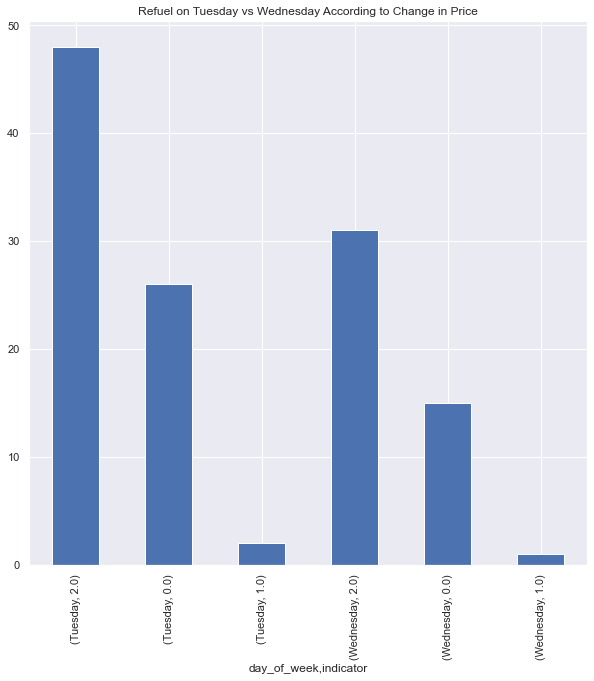

In [66]:
day_indicator = rand.groupby(["day_of_week"])["indicator"].value_counts()
day_indicator.plot(kind = "bar", title = "Refuel on Tuesday vs Wednesday According to Change in Price")

Indicator
- 0 = Decrease
- 1 = Neutral
- 2 = Increase


According to the graph more people:
1. refuel on the first Wednesday when the price goes up.
2. refuel on the first Tuesday when the price goes up.